In [1]:
# Automatically reload every imported module if its source file has changed since the last import, before running any code.
%load_ext autoreload
%autoreload 2


In [1]:
import os
spark_home = os.path.abspath(os.getcwd() + "/spark/spark-3.5.5-bin-hadoop3")
hadoop_home = os.path.abspath(os.getcwd() + "/spark/winutils")
# print(f"I am using the following SPARK_HOME: {spark_home}")
if os.name == 'nt':
    os.environ["HADOOP_HOME"] = f"{hadoop_home}"
    # print(f"Windows detected: set HADOOP_HOME to: {os.environ['HADOOP_HOME']}")
    hadoop_bin = os.path.join(hadoop_home, "bin")
    os.environ["PATH"] = f"{hadoop_bin};{os.environ['PATH']}"
    # print(f"  Also added Hadoop bin directory to PATH: {hadoop_bin}")

import findspark
import pyspark
from pyspark.streaming import StreamingContext

findspark.init(spark_home)
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession.builder.getOrCreate()


In [2]:
papers_df = spark.read.json("data/interim")


# Data structure

Understand what you have and whether it's clean:
- What is the schema of the dataset?
- Are there missing values in key fields like title, summary, main_category, categories, or published?
- Are there duplicated records (`aid`)?

In [3]:
# Schema
papers_df.printSchema()

# Get basic statistics and information
print(f"Dataset size: {papers_df.count()} papers")
print(f"Number of columns: {len(papers_df.columns)}")

# Check for missing values
from pyspark.sql.functions import col, count, when, isnan, isnull
from pyspark.sql.functions import split, size, year, month, explode, round, sum as spark_sum

papers_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) 
                          for c in papers_df.columns]).show()


root
 |-- aid: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- published: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- title: string (nullable = true)

Dataset size: 6803 papers
Number of columns: 6
+---+----------+-------------+---------+-------+-----+
|aid|categories|main_category|published|summary|title|
+---+----------+-------------+---------+-------+-----+
|  0|         0|            0|        0|      0|    0|
+---+----------+-------------+---------+-------+-----+



In [4]:
# Print the first record in a dictionary format with better formatting
from pprint import pprint

# Get the first record as a dictionary
first_record = papers_df.limit(1).toPandas().T.to_dict()[0]

# Pretty print with formatting
print("First record:")
pprint(first_record, width=100, compact=False)


First record:
{'aid': 'http://arxiv.org/abs/2503.21672v1',
 'categories': 'math.CO,cs.DM',
 'main_category': 'math.CO',
 'published': '2025-03-27T16:40:37Z',
 'summary': 'In the Avoider-Enforcer convention of positional games, two players, Avoider\n'
            'and Enforcer, take turns selecting vertices from a hypergraph H. Enforcer wins\n'
            'if, by the time all vertices of H have been selected, Avoider has completely\n'
            'filled an edge of H with her vertices; otherwise, Avoider wins. In this paper,\n'
            'we first give some general results, in particular regarding the outcome of the\n'
            'game and disjoint unions of hypergraphs. We then determine which player has a\n'
            'winning strategy for all hypergraphs of rank 2, and for linear hypergraphs of\n'
            'rank 3 when Avoider plays the last move. The structural characterisations we\n'
            'obtain yield polynomial-time algorithms.',
 'title': 'The Avoider-Enforcer ga

# Main category distribution

Understand your labels before deciding on prediction strategy:
- How many unique values are there in `main_category`?
- What are the top N most frequent `main_category` values?
- Are some `main_category` values very rare or dominant? (e.g., does one class dominate 50% of the data?)
- How many unique `categories` values?
- What’s the average number of `categories` per paper (for multilabel setup)?
- How do `main_category` distributions differ over week? Over day?
- What's the distribution of Arxiv main category (before `.`)?


In [6]:
# Target Analysis: Main Category Distribution and Characteristics

# ---------- 1. Count unique values in main_category ----------
unique_main_categories = papers_df.select("main_category").distinct().count()
print(f"Number of unique main_categories: {unique_main_categories}")


Number of unique main_categories: 143


In [7]:
# ---------- 2. Top N most frequent main_categories ----------
N = 10  # Change this to see more or fewer categories
main_cat_dist = papers_df.groupBy("main_category").count().orderBy("count", ascending=False)
print(f"\nTop {N} most frequent main categories:")
main_cat_dist.show(N, truncate=False)



Top 10 most frequent main categories:
+-----------------+-----+
|main_category    |count|
+-----------------+-----+
|cs.CV            |820  |
|cs.LG            |446  |
|cs.CL            |359  |
|quant-ph         |314  |
|cs.RO            |182  |
|cs.AI            |153  |
|math.AP          |145  |
|cond-mat.mtrl-sci|139  |
|hep-ph           |138  |
|eess.SY          |127  |
+-----------------+-----+
only showing top 10 rows



In [8]:
# ---------- 3. Check for category imbalance ----------
total_papers = papers_df.count()
main_cat_dist_with_pct = main_cat_dist.withColumn(
    "percentage", round((col("count") / total_papers) * 100, 2)
)

print("\nCategory distribution with percentages:")
main_cat_dist_with_pct.show(20, truncate=False)

# Find dominant categories (>10%) and rare categories (<1%)
dominant_categories = main_cat_dist_with_pct.filter("percentage > 5")
rare_categories = main_cat_dist_with_pct.filter("percentage < 1")

print(f"Dominant categories (>5%): {dominant_categories.count()}")
dominant_categories.show(truncate=False)

print(f"Rare categories (<1%): {rare_categories.count()}")
rare_categories.show(truncate=False)



Category distribution with percentages:
+-----------------+-----+----------+
|main_category    |count|percentage|
+-----------------+-----+----------+
|cs.CV            |820  |12.05     |
|cs.LG            |446  |6.56      |
|cs.CL            |359  |5.28      |
|quant-ph         |314  |4.62      |
|cs.RO            |182  |2.68      |
|cs.AI            |153  |2.25      |
|math.AP          |145  |2.13      |
|cond-mat.mtrl-sci|139  |2.04      |
|hep-ph           |138  |2.03      |
|eess.SY          |127  |1.87      |
|math.OC          |117  |1.72      |
|gr-qc            |117  |1.72      |
|eess.SP          |111  |1.63      |
|physics.optics   |105  |1.54      |
|cs.CR            |102  |1.5       |
|hep-th           |101  |1.48      |
|math.NA          |95   |1.4       |
|math.CO          |95   |1.4       |
|cs.HC            |92   |1.35      |
|astro-ph.GA      |91   |1.34      |
+-----------------+-----+----------+
only showing top 20 rows

Dominant categories (>5%): 3
+-------------+-

In [9]:
# ---------- 4. Unique subcategories in categories field ----------
# Assuming categories field contains comma-separated category codes
categories_exploded = papers_df.select(
    explode(split(col("categories"), ",")).alias("subcategory")
)
unique_subcategories = categories_exploded.select("subcategory").distinct().count()
print(f"\nNumber of unique subcategories: {unique_subcategories}")



Number of unique subcategories: 203


In [10]:
from pyspark.sql.functions import concat, lit

cat_dist_with_count = papers_df.withColumn(
    "num_categories", size(split(col("categories"), ","))
)

avg_labels = cat_dist_with_count.agg(
    {"num_categories": "avg"}
).collect()[0][0]

print(f"\nAverage number of categories per paper: {avg_labels:.2f}")

category_dist = cat_dist_with_count.groupBy("num_categories").count()

# Add percentage column
category_dist_with_pct = category_dist.withColumn(
    "percentage", round((col("count") / total_papers) * 100, 2)
)

# Format the output to include both count and percentage
print("\nDistribution of number of categories per paper:")
category_dist_with_pct.select(
    "num_categories", 
    "count", 
    concat(col("percentage").cast("string"), lit("%")).alias("percentage")
).orderBy("num_categories").show(20)



Average number of categories per paper: 1.76

Distribution of number of categories per paper:
+--------------+-----+----------+
|num_categories|count|percentage|
+--------------+-----+----------+
|             1| 3341|    49.11%|
|             2| 2205|    32.41%|
|             3|  907|    13.33%|
|             4|  243|     3.57%|
|             5|   87|     1.28%|
|             6|   18|     0.26%|
|             7|    2|     0.03%|
+--------------+-----+----------+



In [11]:
# ---------- 6. Category distributions over week ----------
from pyspark.sql.functions import weekofyear, date_format, dayofweek, date_sub, expr, to_date

# Convert published field to date components and find the Monday that starts each week
papers_with_date = papers_df.withColumn(
    "pub_date", to_date(col("published"))
).withColumn(
    # Calculate days to subtract to get to Monday (Sunday=1, Monday=2, etc.)
    # For Monday (2) we subtract 0, Tuesday (3) subtract 1, etc.
    "days_from_monday", expr("dayofweek(pub_date) - 2")
).withColumn(
    # Handle Sunday (need to subtract 6 days instead of -1)
    "days_from_monday", 
    when(col("days_from_monday") < 0, 6).otherwise(col("days_from_monday"))
).withColumn(
    # Get the Monday date
    "week_start", date_sub(col("pub_date"), col("days_from_monday"))
).withColumn(
    # Format it as "Mar-31" 
    "week_date", date_format(col("week_start"), "MMM-d")
)

# Count papers by week and category
weekly_cat_dist = papers_with_date.groupBy("week_date", "main_category").count().orderBy("week_date", "count", ascending=False)

# print("\nCategory distribution by week (showing first 20 rows):")
# weekly_cat_dist.show(20, truncate=False)

# Calculate percentage distribution by week
weekly_totals = papers_with_date.groupBy("week_date").count().withColumnRenamed("count", "week_total")

weekly_cat_pct = weekly_cat_dist.join(weekly_totals, "week_date") \
    .withColumn("percentage", round((col("count") / col("week_total")) * 100, 2)) \
    .orderBy("week_date", "percentage", ascending=False)

# print("\nPercentage distribution of categories by week (showing first 20 rows):")
# weekly_cat_pct.select("week_date", "main_category", "count", "week_total", "percentage").show(20, truncate=False)

# Optional: Track specific categories over time
top_categories = main_cat_dist.limit(10).select("main_category").rdd.flatMap(lambda x: x).collect()
top_cat_trend = weekly_cat_pct.filter(col("main_category").isin(top_categories))

print("\nTrend for top 10 categories over time (by week):")
top_cat_trend.orderBy("week_date", "main_category").show(50, truncate=False)

# Add a visualization hint
print("\nNote: The week_date format is 'MMM-d' showing the Monday that starts each week")



Trend for top 10 categories over time (by week):
+---------+-----------------+-----+----------+----------+
|week_date|main_category    |count|week_total|percentage|
+---------+-----------------+-----+----------+----------+
|Apr-14   |cond-mat.mtrl-sci|49   |2361      |2.08      |
|Apr-14   |cs.AI            |45   |2361      |1.91      |
|Apr-14   |cs.CL            |125  |2361      |5.29      |
|Apr-14   |cs.CV            |309  |2361      |13.09     |
|Apr-14   |cs.LG            |151  |2361      |6.4       |
|Apr-14   |cs.RO            |64   |2361      |2.71      |
|Apr-14   |eess.SY          |36   |2361      |1.52      |
|Apr-14   |hep-ph           |54   |2361      |2.29      |
|Apr-14   |math.AP          |51   |2361      |2.16      |
|Apr-14   |quant-ph         |119  |2361      |5.04      |
|Apr-7    |cond-mat.mtrl-sci|49   |2344      |2.09      |
|Apr-7    |cs.AI            |63   |2344      |2.69      |
|Apr-7    |cs.CL            |128  |2344      |5.46      |
|Apr-7    |cs.CV      

In [12]:
import plotly.express as px
import pandas as pd

# Convert Spark DataFrame to Pandas and prepare data
top_cat_pandas = top_cat_trend.orderBy("week_date", "main_category").toPandas()

# Create line chart with Plotly
fig = px.line(
    top_cat_pandas, 
    x='week_date', 
    y='percentage', 
    color='main_category',
    markers=True,
    title='Weekly Trends of Top 10 Categories',
    labels={'week_date': 'Week', 'percentage': 'Percentage (%)'}
)

# Basic layout improvements
fig.update_layout(
    xaxis=dict(tickangle=45),
    yaxis=dict(ticksuffix='%'),
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='top', # Anchor to bottom of legend box
        y=1.02,          # Position just above the plot area
        xanchor='center', # Center horizontally
        x=0.5
    ),
    margin=dict(t=50),   # Add top margin for legend space
    template='plotly_white'
)

# Show the plot
fig.show(render="png")


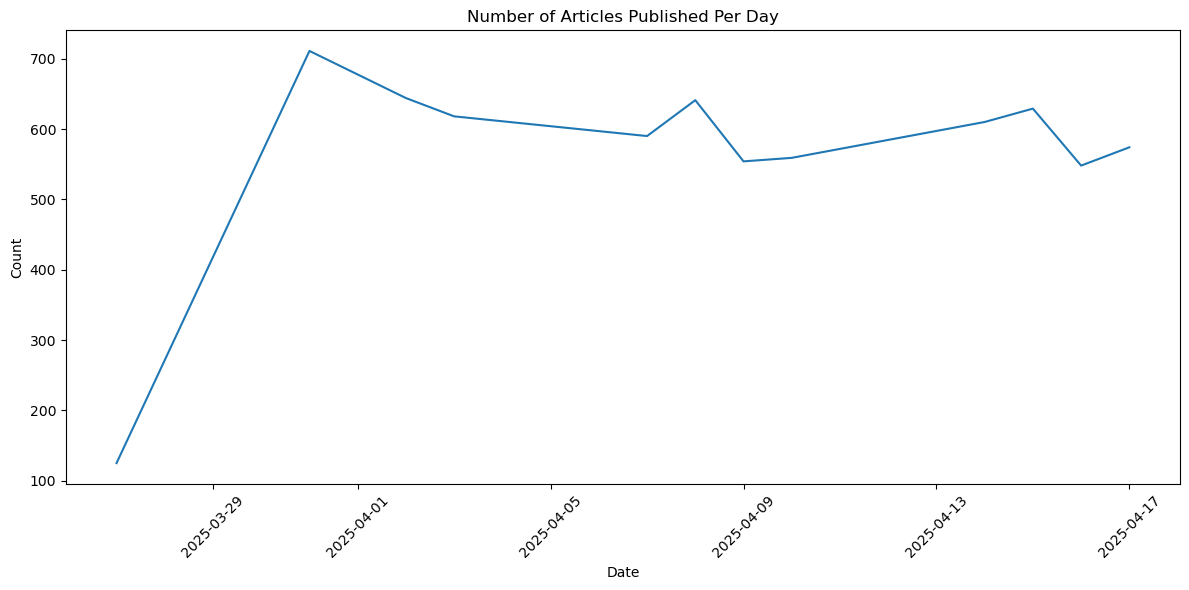

In [13]:
from pyspark.sql.functions import to_date
import matplotlib.pyplot as plt
import seaborn as sns

# Extract date
date_df = papers_df.withColumn("publish_date", to_date("published"))

# Count per day
counts_df = date_df.groupBy("publish_date").count().orderBy("publish_date")

# Convert to Pandas
counts_pdf = counts_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="publish_date", y="count", data=counts_pdf)
plt.title("Number of Articles Published Per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# ---------- 7. Archive distribution ----------

arxiv_main_category = {
    "astro-ph": [
        "astro-ph.CO", "astro-ph.EP", "astro-ph.GA", "astro-ph.HE",
        "astro-ph.IM", "astro-ph.SR"
    ],
    "cond-mat": [
        "cond-mat.dis-nn", "cond-mat.mes-hall", "cond-mat.mtrl-sci",
        "cond-mat.other", "cond-mat.quant-gas", "cond-mat.soft",
        "cond-mat.stat-mech", "cond-mat.str-el", "cond-mat.supr-con"
    ],
    "gr-qc": [
        "gr-qc"
    ],
    "hep": [
        "hep-ex", "hep-lat", "hep-ph", "hep-th"
    ],
    "math-ph": [
        "math-ph"
    ],
    "nlin": [
        "nlin.AO", "nlin.CG", "nlin.CD", "nlin.SI", "nlin.PS"
    ],
    "nucl": [
        "nucl-ex", "nucl-th"
    ],
    "quant-ph": [
        "quant-ph"
    ],
    "physics": [
        "physics.acc-ph", "physics.ao-ph", "physics.app-ph", "physics.atm-clus",
        "physics.atom-ph", "physics.bio-ph", "physics.chem-ph", "physics.class-ph",
        "physics.comp-ph", "physics.data-an", "physics.ed-ph", "physics.flu-dyn",
        "physics.gen-ph", "physics.geo-ph", "physics.hist-ph", "physics.ins-det",
        "physics.med-ph", "physics.optics", "physics.plasm-ph", "physics.pop-ph",
        "physics.soc-ph", "physics.space-ph"
    ],
    "math": [
        "math.AC", "math.AG", "math.AP", "math.AT", "math.CA", "math.CO",
        "math.CT", "math.CV", "math.DG", "math.DS", "math.FA", "math.GM",
        "math.GN", "math.GR", "math.GT", "math.HO", "math.IT", "math.KT",
        "math.LO", "math.MG", "math.MP", "math.NA", "math.NT", "math.OA",
        "math.OC", "math.PR", "math.QA", "math.RA", "math.RT", "math.SG",
        "math.SP", "math.ST"
    ],
    "cs": [
        "cs.AI", "cs.AR", "cs.CC", "cs.CE", "cs.CG", "cs.CL", "cs.CR", "cs.CV",
        "cs.CY", "cs.DB", "cs.DC", "cs.DL", "cs.DM", "cs.DS", "cs.ET", "cs.FL",
        "cs.GL", "cs.GR", "cs.GT", "cs.HC", "cs.IR", "cs.IT", "cs.LG", "cs.LO",
        "cs.MA", "cs.MM", "cs.MS", "cs.NA", "cs.NE", "cs.NI", "cs.OH", "cs.OS",
        "cs.PF", "cs.PL", "cs.RO", "cs.SC", "cs.SD", "cs.SE", "cs.SI", "cs.SY"
    ],
    "q-bio": [
        "q-bio.BM", "q-bio.CB", "q-bio.GN", "q-bio.MN", "q-bio.NC", "q-bio.OT",
        "q-bio.PE", "q-bio.QM", "q-bio.SC", "q-bio.TO"
    ],
    "q-fin": [
        "q-fin.CP", "q-fin.EC", "q-fin.GN", "q-fin.MF", "q-fin.PM", "q-fin.PR",
        "q-fin.RM", "q-fin.ST", "q-fin.TR"
    ],
    "stat": [
        "stat.AP", "stat.CO", "stat.ME", "stat.ML", "stat.OT", "stat.TH"
    ],
    "eess": [
        "eess.AS", "eess.IV", "eess.SP", "eess.SY"
    ],
    "econ": [
        "econ.EM", "econ.GN", "econ.TH"
    ],
}

from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Create mapping with dictionary comprehension
category_to_parent = {child: parent for parent, children in arxiv_main_category.items() for child in children}

# Define mapping UDF
@udf(StringType())
def map_category(category):
    return category_to_parent.get(category, "other")

# Add column with single function call
papers_df = papers_df.withColumn("arxiv_main_category", map_category(col("main_category")))


Number of unique arxiv_main_categories: 16

ArXiv Main Category Distribution:
+-------------------+-----+----------+
|arxiv_main_category|count|percentage|
+-------------------+-----+----------+
|cs                 |2897 |42.58     |
|math               |1157 |17.01     |
|cond-mat           |496  |7.29      |
|astro-ph           |425  |6.25      |
|physics            |422  |6.2       |
|quant-ph           |314  |4.62      |
|eess               |308  |4.53      |
|hep                |293  |4.31      |
|stat               |141  |2.07      |
|gr-qc              |117  |1.72      |
|nucl               |68   |1.0       |
|q-bio              |52   |0.76      |
|econ               |47   |0.69      |
|nlin               |26   |0.38      |
|q-fin              |22   |0.32      |
|math-ph            |18   |0.26      |
+-------------------+-----+----------+


Class Imbalance Ratio (max/min): 160.94
Classes with <1% representation: 5


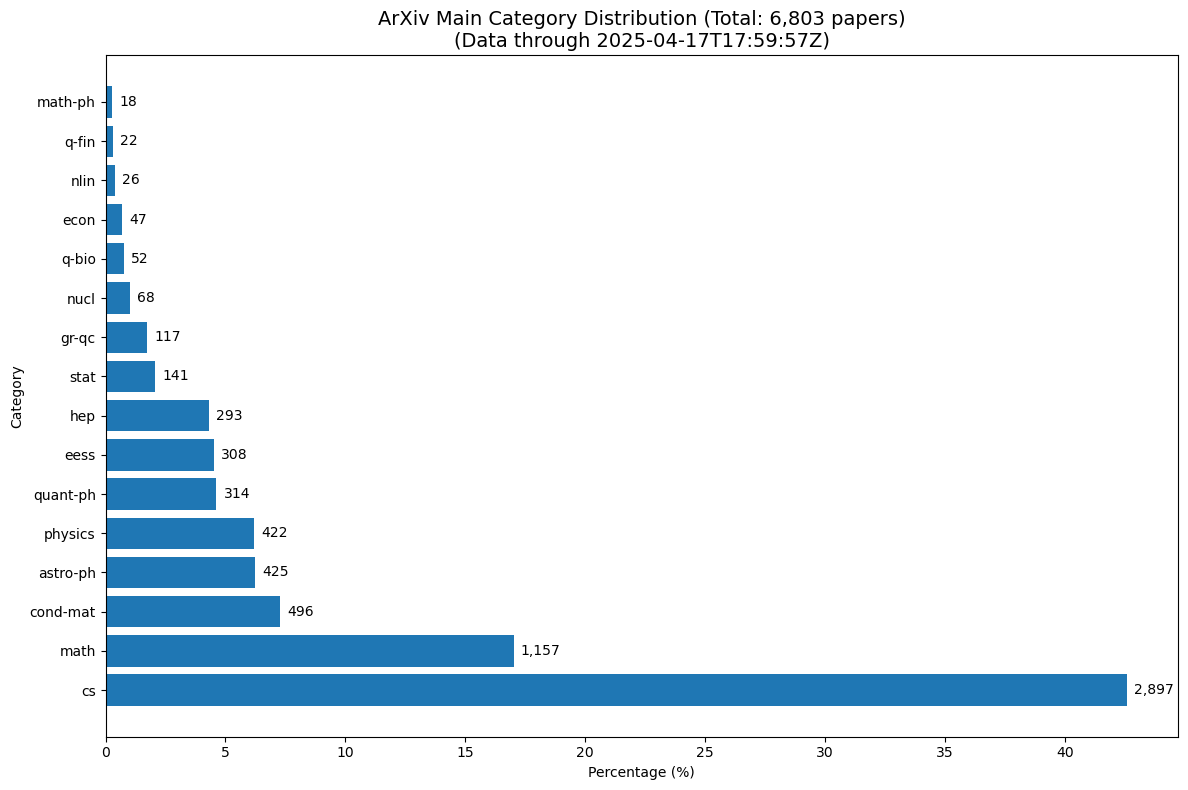

In [15]:
# Get distribution of arxiv_main_category
from pyspark.sql.functions import col, count, round
from pyspark.sql.functions import max as spark_max

# Count the unique arxiv_main_category values
unique_arxiv_main_categories = papers_df.select("arxiv_main_category").distinct().count()
print(f"Number of unique arxiv_main_categories: {unique_arxiv_main_categories}")


# Count categories and calculate percentages
total_papers = papers_df.count()
cat_distribution = papers_df.groupBy("arxiv_main_category") \
    .count() \
    .withColumn("percentage", round((col("count") / total_papers) * 100, 2)) \
    .orderBy("count", ascending=False)

# Display distribution
print("\nArXiv Main Category Distribution:")
cat_distribution.show(truncate=False)

# Check class imbalance
max_count = cat_distribution.agg({"count": "max"}).collect()[0][0]
min_count = cat_distribution.agg({"count": "min"}).collect()[0][0]
print(f"\nClass Imbalance Ratio (max/min): {max_count/min_count:.2f}")

# Count classes with less than 1% representation
rare_classes = cat_distribution.filter("percentage < 1").count()
print(f"Classes with <1% representation: {rare_classes}")

# Optional: Quick visualization using pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas for easy plotting
latest_date = papers_df.agg(spark_max("published")).collect()[0][0]
pd_distribution = cat_distribution.toPandas()

# Create horizontal bar chart
plt.figure(figsize=(12, 8))  # Slightly larger figure to accommodate annotations
bars = plt.barh(pd_distribution['arxiv_main_category'], pd_distribution['percentage'])
plt.xlabel('Percentage (%)')
plt.ylabel('Category')
plt.title(f'ArXiv Main Category Distribution (Total: {total_papers:,} papers)\n(Data through {latest_date})', 
         fontsize=14)
# Add count annotations to each bar
for i, bar in enumerate(bars):
    count = pd_distribution.iloc[i]['count']
    plt.text(
        bar.get_width() + 0.3,  # Position slightly to the right of the bar
        bar.get_y() + bar.get_height()/2,  # Vertical center of the bar
        f'{count:,}',  # Format with commas for thousands
        va='center'  # Vertically centered
    )

plt.tight_layout()
plt.show()


Total number of categories in heatmap: 17


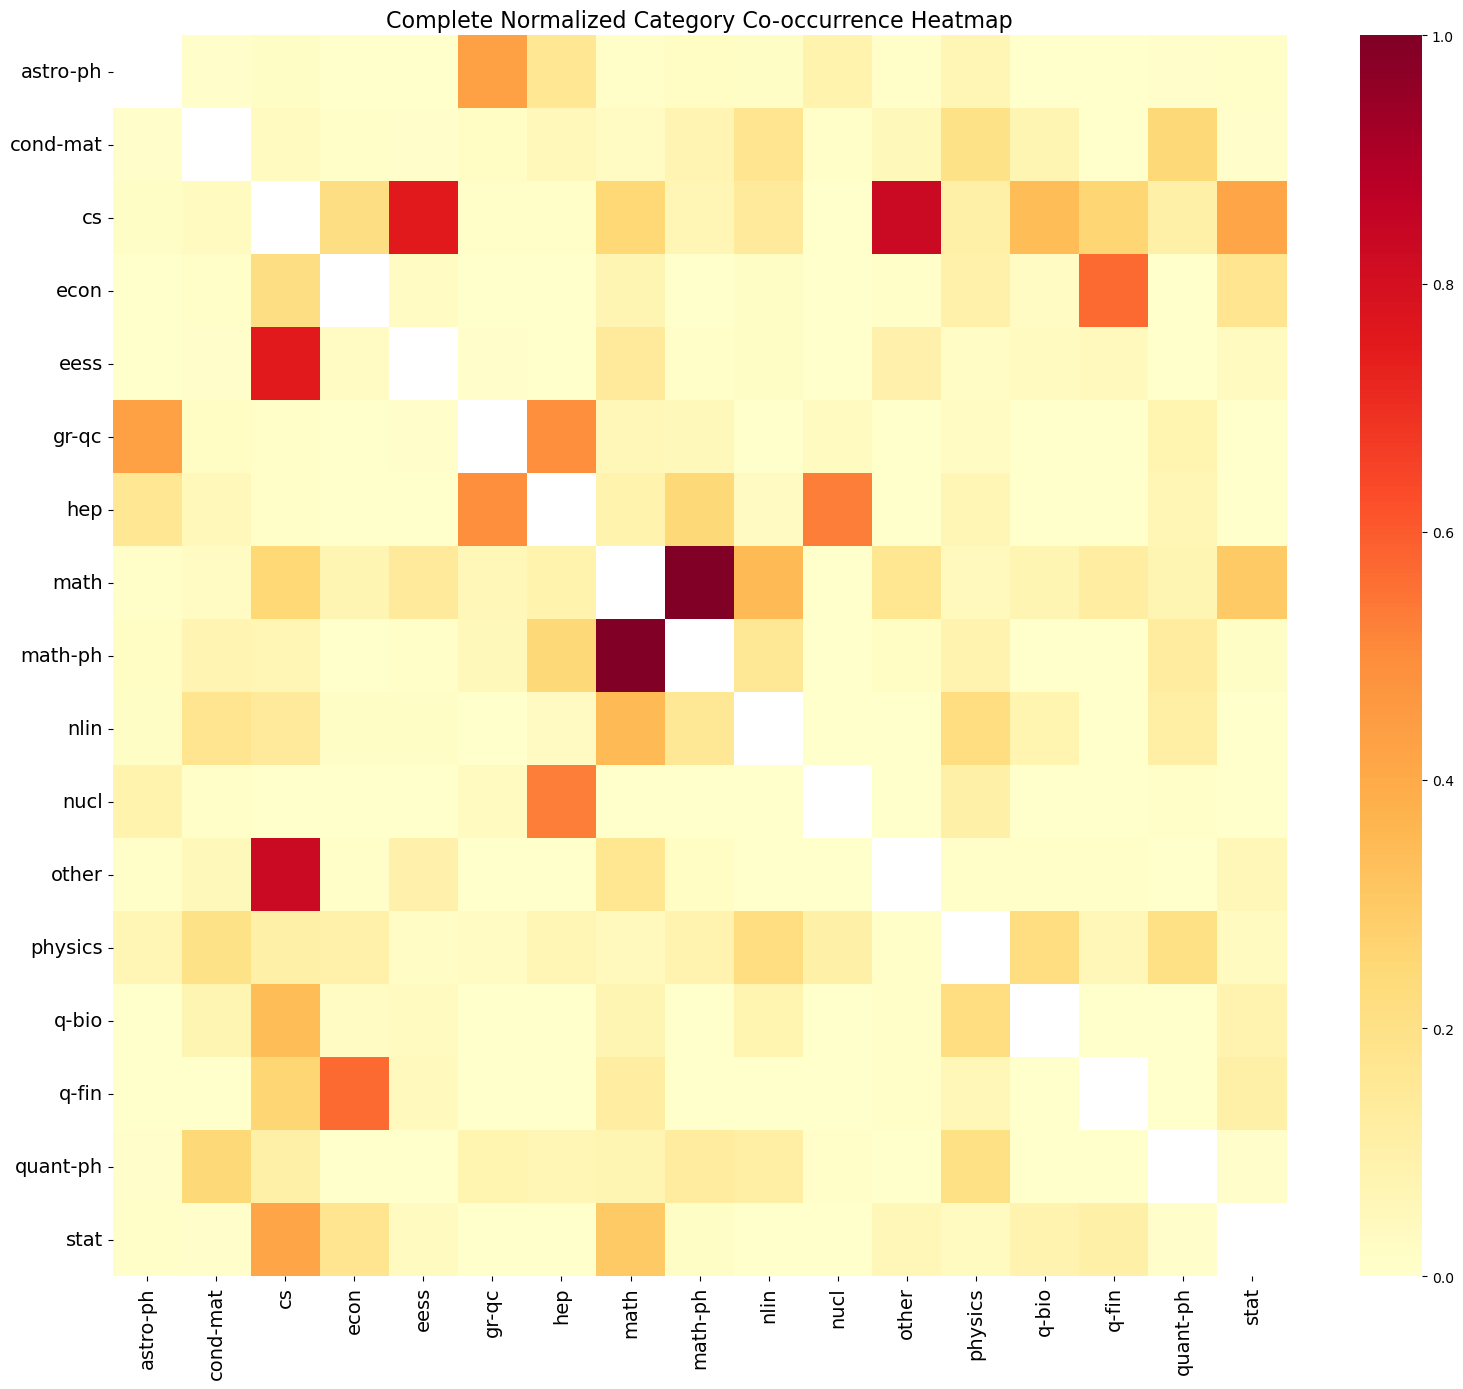

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np

# Collect category data to Pandas
category_pdf = papers_df.select("categories").toPandas()
category_pdf["category_list"] = category_pdf["categories"].str.split(",")

# Convert the Spark UDF to a regular Python function for Pandas
def map_categories_pandas(category_list):
    """Map each category in a list to its parent category"""
    # Handle empty lists or None values
    if not category_list:
        return []
    # Map each category to its parent, defaulting to "other" if not found
    return [category_to_parent.get(cat, "other") for cat in category_list]

# Apply the function to the Pandas DataFrame
category_pdf["arxiv_category_list"] = category_pdf["category_list"].apply(map_categories_pandas)

# Get all unique categories for complete visualization
all_categories = set()
for cats in category_pdf["arxiv_category_list"]:
    all_categories.update(cats)
all_cat_list = sorted(list(all_categories))

print(f"Total number of categories in heatmap: {len(all_cat_list)}")

# Create multi-hot encoding with all categories
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=all_cat_list)
multi_hot = mlb.fit_transform(category_pdf["arxiv_category_list"])

# Calculate raw co-occurrence matrix
co_matrix = (multi_hot.T @ multi_hot)

# Calculate individual category frequencies (diagonal elements)
category_counts = np.diag(co_matrix)

# Create normalized matrix using minimum count normalization
norm_matrix = np.zeros_like(co_matrix, dtype=float)
for i in range(len(all_cat_list)):
    for j in range(len(all_cat_list)):
        # Normalize by minimum of the individual counts
        min_count = min(category_counts[i], category_counts[j])
        if min_count > 0:  # Avoid division by zero
            norm_matrix[i, j] = co_matrix[i, j] / min_count

# Convert to DataFrame
norm_df = pd.DataFrame(norm_matrix, index=all_cat_list, columns=all_cat_list)

# Create a mask to hide the diagonal (optional)
mask = np.eye(len(all_cat_list), dtype=bool)

# Plot normalized heatmap
plt.figure(figsize=(16, 14))  # Larger figure to accommodate all categories
sns.heatmap(
    norm_df, 
    cmap="YlOrRd", 
    mask=mask,  # Hide the diagonal (self-association)
    vmin=0, 
    vmax=1,
    annot=False,  # Too many categories for annotations
    xticklabels=True, 
    yticklabels=True
)
plt.title("Complete Normalized Category Co-occurrence Heatmap", fontsize=16)
plt.xticks(rotation=90, fontsize=14)  # Rotate and shrink labels for readability
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()
plt.show()


In [17]:
# ----- Inspect which categories have been mapped to "other" -----
# Get raw counts directly from source columns
raw_main_categories = papers_df.select("main_category").distinct()
raw_main_count = raw_main_categories.count()
print(f"Raw main_category distinct count: {raw_main_count}")

# Get all raw categories from the categories field
raw_categories = papers_df.select(
    explode(split(col("categories"), ",")).alias("category")
).distinct()
raw_categories_count = raw_categories.count()
print(f"Raw distinct categories from categories field: {raw_categories_count}")


Raw main_category distinct count: 143
Raw distinct categories from categories field: 203


In [18]:
# Print the full lists to see exactly what's in each set
main_cat_list = papers_df.select("main_category").distinct().collect()
main_cat_values = [row.main_category for row in main_cat_list]
print("All distinct main_category values:")
for cat in sorted(main_cat_values):
    print(f"  - '{cat}'")

# Get all unique categories from categories field
categories_list = papers_df.select(
    explode(split(col("categories"), ",")).alias("category")
).distinct().collect()
categories_values = [row.category for row in categories_list]
print("\nAll distinct category values from categories field:")
for cat in sorted(categories_values):
    if cat not in main_cat_values:
        print(f"  - '{cat}' (not in main_category)")
    else:
        print(f"  - '{cat}'")

All distinct main_category values:
  - 'astro-ph.CO'
  - 'astro-ph.EP'
  - 'astro-ph.GA'
  - 'astro-ph.HE'
  - 'astro-ph.IM'
  - 'astro-ph.SR'
  - 'cond-mat.dis-nn'
  - 'cond-mat.mes-hall'
  - 'cond-mat.mtrl-sci'
  - 'cond-mat.other'
  - 'cond-mat.quant-gas'
  - 'cond-mat.soft'
  - 'cond-mat.stat-mech'
  - 'cond-mat.str-el'
  - 'cond-mat.supr-con'
  - 'cs.AI'
  - 'cs.AR'
  - 'cs.CC'
  - 'cs.CE'
  - 'cs.CG'
  - 'cs.CL'
  - 'cs.CR'
  - 'cs.CV'
  - 'cs.CY'
  - 'cs.DB'
  - 'cs.DC'
  - 'cs.DL'
  - 'cs.DM'
  - 'cs.DS'
  - 'cs.ET'
  - 'cs.FL'
  - 'cs.GR'
  - 'cs.GT'
  - 'cs.HC'
  - 'cs.IR'
  - 'cs.IT'
  - 'cs.LG'
  - 'cs.LO'
  - 'cs.MA'
  - 'cs.MM'
  - 'cs.MS'
  - 'cs.NE'
  - 'cs.NI'
  - 'cs.OH'
  - 'cs.OS'
  - 'cs.PF'
  - 'cs.PL'
  - 'cs.RO'
  - 'cs.SC'
  - 'cs.SD'
  - 'cs.SE'
  - 'cs.SI'
  - 'econ.EM'
  - 'econ.GN'
  - 'econ.TH'
  - 'eess.AS'
  - 'eess.IV'
  - 'eess.SP'
  - 'eess.SY'
  - 'gr-qc'
  - 'hep-ex'
  - 'hep-lat'
  - 'hep-ph'
  - 'hep-th'
  - 'math-ph'
  - 'math.AC'
  - 'math.AG'
 

# Input features

Evaluate your input features `title` and `summary`:
- What is the average/median/min/max length (in words or characters) of:
    - title
    - summary
    - title + summary?
- Are there unusually short or long texts that should be filtered?
- Are there stopwords or LaTeX/math formatting (\\mathsf, etc.) that should be removed?
- Are there phrases or token patterns in title and summary that can be related to `main_category`?


In [19]:
from pyspark.sql.functions import length, size, split, col, expr, percentile_approx
from pyspark.sql.functions import min as spark_min, max as spark_max, avg as spark_avg, sum as spark_sum
from pyspark.ml.feature import StopWordsRemover, NGram, CountVectorizer, Tokenizer

# ---------- 1. Text Length Statistics ----------
text_stats = papers_df.select(
    length("title").alias("title_chars"),
    size(split("title", " ")).alias("title_words"),
    length("summary").alias("summary_chars"),
    size(split("summary", " ")).alias("summary_words")
).withColumn(
    "combined_chars", col("title_chars") + col("summary_chars")
).withColumn(
    "combined_words", col("title_words") + col("summary_words")
)

# Calculate statistics
stats = text_stats.agg(
    spark_min("title_chars"), spark_max("title_chars"), spark_avg("title_chars"), percentile_approx("title_chars", 0.5),
    spark_min("title_words"), spark_max("title_words"), spark_avg("title_words"),
    spark_min("summary_chars"), spark_max("summary_chars"), spark_avg("summary_chars"), 
    spark_min("summary_words"), spark_max("summary_words"), spark_avg("summary_words"),
    spark_min("combined_chars"), spark_max("combined_chars"), spark_avg("combined_chars"),
    spark_min("combined_words"), spark_max("combined_words"), spark_avg("combined_words")
).collect()[0]

print("\nText Statistics (min, max, avg):")
print(f"Title: {stats[0]}-{stats[1]} chars ({stats[2]:.1f} avg), {stats[4]}-{stats[5]} words ({stats[6]:.1f} avg)")
print(f"Summary: {stats[7]}-{stats[8]} chars ({stats[9]:.1f} avg), {stats[10]}-{stats[11]} words ({stats[12]:.1f} avg)")
print(f"Combined: {stats[13]}-{stats[14]} chars ({stats[15]:.1f} avg), {stats[16]}-{stats[17]} words ({stats[18]:.1f} avg)")



Text Statistics (min, max, avg):
Title: 9-242 chars (81.5 avg), 1-40 words (10.8 avg)
Summary: 74-2168 chars (1169.0 avg), 12-294 words (147.7 avg)
Combined: 132-2233 chars (1250.6 avg), 17-305 words (158.5 avg)


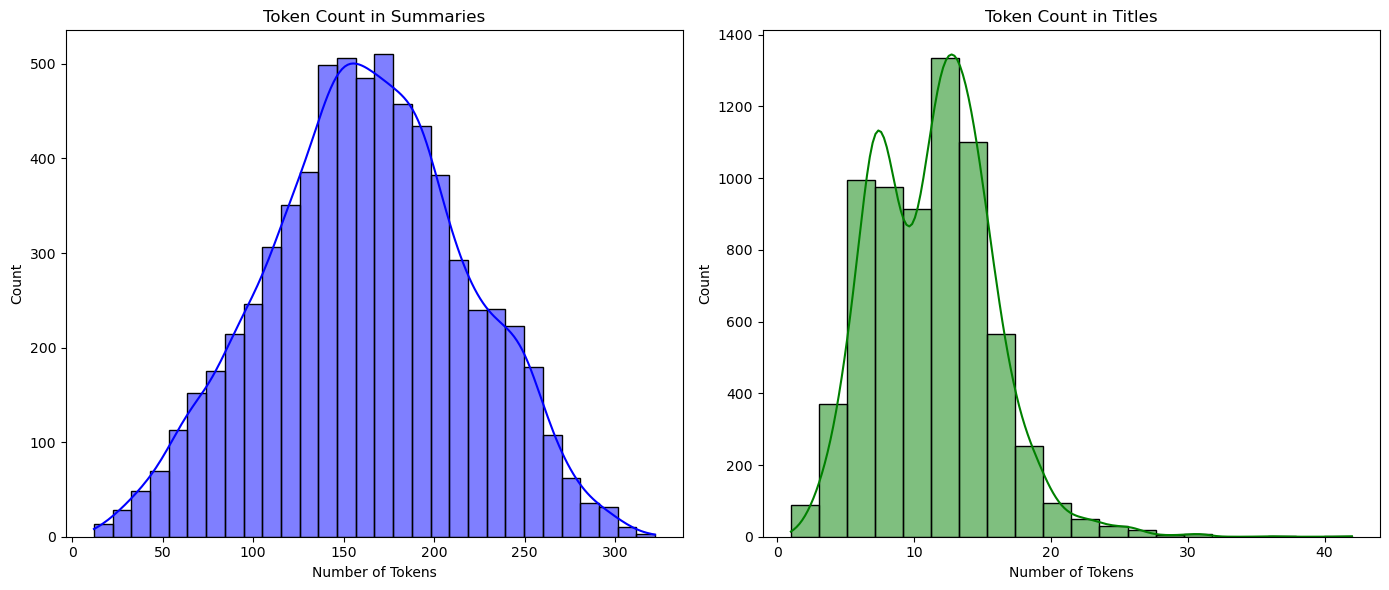

In [20]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import size

# Create tokenizers for both title and summary
title_tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens_arr")
summary_tokenizer = Tokenizer(inputCol="summary", outputCol="summary_tokens_arr")

# Apply tokenizers to get arrays of tokens
tokenized_df = title_tokenizer.transform(summary_tokenizer.transform(papers_df))

# Count the number of tokens in each array
better_token_df = tokenized_df.withColumn("summary_tokens", size("summary_tokens_arr")) \
                             .withColumn("title_tokens", size("title_tokens_arr"))

# Convert to pandas for visualization
token_pdf = better_token_df.select("summary_tokens", "title_tokens").toPandas()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot summary tokens histogram
sns.histplot(token_pdf["summary_tokens"], bins=30, kde=True, ax=ax1, color="blue")
ax1.set_title("Token Count in Summaries")
ax1.set_xlabel("Number of Tokens")
ax1.set_ylabel("Count")

# Plot title tokens histogram
sns.histplot(token_pdf["title_tokens"], bins=20, kde=True, ax=ax2, color="green") 
ax2.set_title("Token Count in Titles")
ax2.set_xlabel("Number of Tokens")
ax2.set_ylabel("Count")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [21]:
# ---------- 2. Check for LaTeX and Math formatting ----------
latex_pattern = r'\\[a-zA-Z]+'
latex_counts = papers_df.select(
    (size(expr(f"regexp_extract_all(title, '{latex_pattern}', 0)")) > 0).cast("int").alias("title_has_latex"),
    (size(expr(f"regexp_extract_all(summary, '{latex_pattern}', 0)")) > 0).cast("int").alias("summary_has_latex")
).agg(
    spark_sum("title_has_latex"), 
    spark_sum("summary_has_latex")
).collect()[0]

print(f"\nLaTeX Usage:")
print(f"Papers with LaTeX in title: {latex_counts[0]} ({latex_counts[0]/papers_df.count()*100:.1f}%)")
print(f"Papers with LaTeX in summary: {latex_counts[1]} ({latex_counts[1]/papers_df.count()*100:.1f}%)")



LaTeX Usage:
Papers with LaTeX in title: 0 (0.0%)
Papers with LaTeX in summary: 0 (0.0%)


In [22]:
from pyspark.sql.functions import explode, col, count as spark_count, trim, lower, regexp_replace

# 1. Better text cleaning before processing
clean_papers = papers_df.withColumn(
    "clean_title", 
    trim(regexp_replace(lower(col("title")), "[^a-zA-Z0-9\\s]", " "))
)

# 2. Apply tokenization pipeline
tokenizer = Tokenizer(inputCol="clean_title", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered")
bigram = NGram(n=2, inputCol="filtered", outputCol="bigrams")

# 3. Generate and filter meaningful bigrams
pipeline_result = bigram.transform(remover.transform(tokenizer.transform(clean_papers)))
bigram_counts = pipeline_result.select(
    explode("bigrams").alias("bigram")
).filter(
    # Multiple filters to ensure quality bigrams
    (length(trim(col("bigram"))) > 3) &                   # Reasonable length
    (~col("bigram").contains("  ")) &                     # No double spaces
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))   # Start/end with alphanumeric
).groupBy(
    "bigram"
).agg(
    spark_count("*").alias("count")
).orderBy(
    col("count").desc()
)

# 4. Show results
print("\nTop 10 bigrams in titles:")
for row in bigram_counts.limit(10).collect():
    print(f"'{row.bigram}': {row['count']}")
    


Top 10 bigrams in titles:
'language models': 146
'large language': 104
'reinforcement learning': 66
'neural networks': 62
'machine learning': 60
'black hole': 45
'vision language': 44
'deep learning': 38
'x ray': 37
'language model': 36


In [23]:
from pyspark.sql.functions import explode, col, count as spark_count

# 1. Process all papers once with category information
category_bigrams = clean_papers.select(
    "main_category", 
    "clean_title"
).transform(
    # Apply the same pipeline to all papers at once
    lambda df: bigram.transform(remover.transform(tokenizer.transform(df)))
)

# 2. Extract, filter and count bigrams with categories in one operation
bigram_by_category = category_bigrams.select(
    "main_category",
    explode("bigrams").alias("bigram")
).filter(
    # Apply same quality filters as main analysis 
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "main_category", "bigram"
).count().orderBy(
    col("main_category"), col("count").desc()
)

# 3. Display top bigrams for selected categories in one efficient loop
top_categories = papers_df.groupBy("main_category").count() \
                          .orderBy("count", ascending=False) \
                          .limit(10) \
                          .select("main_category") \
                          .rdd.flatMap(lambda x: x).collect()


print("\nTop 5 bigrams per category:")
for category in top_categories[:10]:
    print(f"\n{category}:")
    top_for_category = bigram_by_category.filter(col("main_category") == category).limit(5).collect()
    for row in top_for_category:
        print(f"  '{row.bigram}': {row['count']}")


Top 5 bigrams per category:

cs.CV:
  'vision language': 33
  'language models': 22
  'remote sensing': 19
  'object detection': 18
  'self supervised': 16

cs.LG:
  'reinforcement learning': 28
  'neural networks': 22
  'time series': 18
  'language models': 14
  'federated learning': 13

cs.CL:
  'language models': 74
  'large language': 52
  'retrieval augmented': 17
  'language model': 13
  'augmented generation': 8

quant-ph:
  'variational quantum': 11
  'quantum error': 8
  'quantum computing': 5
  'machine learning': 5
  'quantum state': 4

cs.RO:
  'reinforcement learning': 8
  'autonomous driving': 8
  'human robot': 7
  'path planning': 5
  'sim real': 4

cs.AI:
  'language models': 10
  'large language': 8
  'reinforcement learning': 7
  'llm based': 5
  'llm agents': 5

math.AP:
  'schr dinger': 12
  'well posedness': 7
  'normalized solutions': 5
  'navier stokes': 5
  'parabolic equations': 4

cond-mat.mtrl-sci:
  'x ray': 6
  'machine learning': 6
  'two dimensional': 

In [24]:
from pyspark.sql.functions import explode, col, count as spark_count, trim, lower, regexp_replace, length

# ----------------- Summary Bigram Analysis -----------------

# 1. Clean the summary text
clean_papers_summary = papers_df.withColumn(
    "clean_summary", 
    trim(regexp_replace(lower(col("summary")), "[^a-zA-Z0-9\\s]", " "))
)

# 2. Apply tokenization pipeline
sum_tokenizer = Tokenizer(inputCol="clean_summary", outputCol="summary_tokens")
sum_remover = StopWordsRemover(inputCol="summary_tokens", outputCol="summary_filtered")
sum_bigram = NGram(n=2, inputCol="summary_filtered", outputCol="summary_bigrams")

# 3. Generate and filter meaningful bigrams
summary_pipeline = sum_bigram.transform(
    sum_remover.transform(
        sum_tokenizer.transform(clean_papers_summary)
    )
)

# 4. Extract and count bigrams
summary_bigram_counts = summary_pipeline.select(
    explode("summary_bigrams").alias("bigram")
).filter(
    # Same quality filters as used for titles
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "bigram"
).agg(
    spark_count("*").alias("count")
).orderBy(
    col("count").desc()
)

# 5. Show top bigrams in summaries
print("\nTop 10 bigrams in summaries:")
for row in summary_bigram_counts.limit(10).collect():
    print(f"'{row.bigram}': {row['count']}")

# 6. Category-specific summary bigrams in a single efficient operation
category_summary_bigrams = clean_papers_summary.select(
    "main_category",
    "clean_summary"
).transform(
    # Apply the pipeline to all papers at once
    lambda df: sum_bigram.transform(sum_remover.transform(sum_tokenizer.transform(df)))
)

# 7. Process all categories at once
summary_bigrams_by_category = category_summary_bigrams.select(
    "main_category",
    explode("summary_bigrams").alias("bigram")
).filter(
    # Same quality filters
    (length(trim(col("bigram"))) > 3) &
    (~col("bigram").contains("  ")) &
    (col("bigram").rlike("^[a-zA-Z0-9].*[a-zA-Z0-9]$"))
).groupBy(
    "main_category", "bigram"
).count().orderBy(
    col("main_category"), col("count").desc()
)

# 8. Display top summary bigrams by category
print("\nTop 5 summary bigrams per category:")
for category in top_categories[:5]:  # Limiting to top 5 categories for brevity
    print(f"\n{category}:")
    top_for_category = summary_bigrams_by_category.filter(col("main_category") == category).limit(5).collect()
    for row in top_for_category:
        print(f"  '{row.bigram}': {row['count']}")
        


Top 10 bigrams in summaries:
'state art': 806
'real world': 688
'language models': 681
'large language': 595
'large scale': 385
'machine learning': 332
'experimental results': 327
'extensive experiments': 319
'fine tuning': 301
'results show': 295

Top 5 summary bigrams per category:

cs.CV:
  'state art': 341
  'real world': 204
  'extensive experiments': 188
  'github com': 146
  'language models': 130

cs.LG:
  'real world': 99
  'state art': 99
  'machine learning': 94
  'reinforcement learning': 84
  'neural networks': 78

cs.CL:
  'language models': 273
  'large language': 238
  'fine tuning': 66
  'state art': 65
  'open source': 47

quant-ph:
  'quantum systems': 49
  'quantum computing': 48
  'variational quantum': 38
  'quantum algorithms': 36
  'quantum circuits': 34

cs.RO:
  'real world': 86
  'real time': 38
  'state art': 30
  'reinforcement learning': 27
  'autonomous driving': 26


In [25]:
# Are certain keywords more correlated with certain categories?

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, expr, udf
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml import Pipeline

# 1. Prepare data - clean text and add category
keyword_data = papers_df.select(
    "main_category",
    regexp_replace(lower(col("title")), "[^a-zA-Z0-9\\s]", " ").alias("cleaned_text")
)

# 2. Create ML pipeline for feature extraction
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

# 3. Fit the pipeline and transform data
model = pipeline.fit(keyword_data)
transformed = model.transform(keyword_data)

# 4. Calculate keyword significance for each category
# Get vocabulary from the HashingTF model (using the vocabulary from token counts)
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="filtered", outputCol="counts", minDF=10)
cv_model = cv.fit(transformed)
vocab = cv_model.vocabulary

# 5. For each category, find most distinctive keywords
print("\nTop keywords correlated with categories:")
for category in top_categories[:10]:  # Show top 20 categories
    # Filter for this category and collect weighted term frequencies
    category_docs = transformed.filter(col("main_category") == category)
    
    # Extract top terms for this category using the TF-IDF weights
    @udf(returnType=ArrayType(StringType()))
    def get_top_terms(words, features):
        # Pair words with their feature weights and sort by weight
        return [w for _, w in sorted([(features[i], w) for i, w in enumerate(words) if i < len(features)], 
                                   key=lambda x: x[0], reverse=True)[:10]]
    
    # Apply the UDF to get top terms for each document
    category_terms = category_docs.withColumn("top_terms", get_top_terms("filtered", "features"))
    
    # Count term frequency across all documents in this category
    top_terms = category_terms.select(explode("filtered").alias("term")).groupBy("term").count()
    
    # Get overall corpus frequency for comparison
    corpus_freq = transformed.select(explode("filtered").alias("term")).groupBy("term").count().withColumnRenamed("count", "corpus_count")
    
    # Calculate term importance as ratio of category frequency to corpus frequency
    term_importance = top_terms.join(corpus_freq, "term").withColumn(
        "importance", col("count") / col("corpus_count")
    ).orderBy("importance", ascending=False)
    
    # Display results
    print(f"\n{category}:")
    for row in term_importance.filter(col("count") > 5).limit(10).collect():
        print(f"  '{row.term}': {row['count']} occurrences, {row.importance:.2f} importance")



Top keywords correlated with categories:

cs.CV:
  'occupancy': 6 occurrences, 1.00 importance
  'imagery': 6 occurrences, 1.00 importance
  'vocabulary': 6 occurrences, 1.00 importance
  'clip': 6 occurrences, 1.00 importance
  'saliency': 6 occurrences, 1.00 importance
  'anything': 10 occurrences, 0.91 importance
  'monocular': 9 occurrences, 0.90 importance
  'pose': 17 occurrences, 0.89 importance
  'facial': 7 occurrences, 0.88 importance
  'sam': 7 occurrences, 0.88 importance

cs.LG:
  'federated': 29 occurrences, 0.71 importance
  'protein': 7 occurrences, 0.58 importance
  'predicting': 8 occurrences, 0.57 importance
  'unlearning': 6 occurrences, 0.55 importance
  'forecasting': 12 occurrences, 0.55 importance
  'series': 21 occurrences, 0.50 importance
  'cache': 6 occurrences, 0.46 importance
  'interpretable': 7 occurrences, 0.44 importance
  'reinforcement': 31 occurrences, 0.41 importance
  'balancing': 6 occurrences, 0.40 importance

cs.CL:
  'multilingual': 17 occurr

# Correlation structure

Since these are text fields, correlation is better studied via embedding similarity or mutual information:
- Correlation between `summary`, `title` and `main_category`
- Correlation between `summary`, `title` and broader `arxiv_main_category`
- Some overlap in words between `title` and `summary`

In [26]:
# ---- 1. Embedding similarity between text features and target columns ----
from src.utils import analyze_similarity

analyze_similarity(
    papers_df, 
    text_feature="summary", 
    target="main_category"
)

analyze_similarity(
    papers_df, 
    text_feature="summary", 
    target="arxiv_main_category"
)

analyze_similarity(
    papers_df, 
    text_feature="title", 
    target="main_category"
)

analyze_similarity(
    papers_df, 
    text_feature="title", 
    target="arxiv_main_category"
)


Device set to use cpu


Computing similarity between 'summary' and 'main_category'...

Category similarity statistics (sorted by avg similarity):
+----------------+--------------+-----------------+---------------+
|main_category   |avg_similarity|stddev_similarity|avg ± std      |
+----------------+--------------+-----------------+---------------+
|physics.ed-ph   |0.3767        |0.0755           |0.3767 ± 0.0755|
|physics.atom-ph |0.2724        |0.0807           |0.2724 ± 0.0807|
|physics.bio-ph  |0.2491        |0.0695           |0.2491 ± 0.0695|
|astro-ph.EP     |0.2413        |0.0568           |0.2413 ± 0.0568|
|cs.AI           |0.2403        |0.0736           |0.2403 ± 0.0736|
|q-bio.MN        |0.2315        |NULL             |0.2315         |
|physics.chem-ph |0.2309        |0.0724           |0.2309 ± 0.0724|
|astro-ph.GA     |0.2252        |0.0471           |0.2252 ± 0.0471|
|math.HO         |0.224         |0.1469           |0.224 ± 0.1469 |
|physics.optics  |0.2184        |0.0836           |0.2184 ± 0.

In [27]:
# 2. Token overlap between title and summary

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

def jaccard_similarity(title, summary):
    set_title = set(title.lower().split())
    set_summary = set(summary.lower().split())
    intersection = len(set_title & set_summary)
    union = len(set_title | set_summary)
    return float(intersection) / union if union > 0 else 0.0

jaccard_udf = udf(jaccard_similarity, FloatType())

df_overlap = papers_df.withColumn("title_summary_overlap", jaccard_udf(col("title"), col("summary")))
df_overlap.select("title_summary_overlap").describe().show()

# The Jaccard similarity of 0.07 ± 0.04 means only 7% overlap on average, which is minimal.


+-------+---------------------+
|summary|title_summary_overlap|
+-------+---------------------+
|  count|                 6803|
|   mean|  0.06991751713361458|
| stddev|  0.04032002812838081|
|    min|                  0.0|
|    max|            0.7777778|
+-------+---------------------+

